In [183]:
import pandas as pd
import pingouin as pg
import lightgbm as lgb
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

csv_path = 'outlier_removed.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)
# 데이터 확인
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,0,1,1,3.0,4,2,1,1,6.641182,low-mid
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,1,1,1,4.0,4,4,1,1,4.941642,low-mid
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,1,1,1,4.0,4,4,1,1,4.875197,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,0,1,1,4.0,4,4,1,1,4.290459,mid
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,1,1,1,4.0,4,4,1,1,4.077537,mid
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,0,1,1,4.0,4,4,0,1,5.703782,mid


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22308 entries, 36121 to 1366723228243064949
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        22308 non-null  object 
 1   neighbourhood_group_cleansed  22308 non-null  object 
 2   latitude                      22308 non-null  float64
 3   longitude                     22308 non-null  float64
 4   price                         22308 non-null  float64
 5   estimated_occupancy_l365d     22308 non-null  int64  
 6   estimated_revenue_l365d       22308 non-null  float64
 7   availability_60               22308 non-null  int64  
 8   availability_365              22308 non-null  int64  
 9   instant_bookable              22308 non-null  int64  
 10  is_long_term                  22308 non-null  int64  
 11  is_activate                   22308 non-null  int64  
 12  amenities                     22308 non-null  o

In [185]:
df.columns

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'availability_60', 'availability_365',
       'instant_bookable', 'is_long_term', 'is_activate', 'amenities',
       'amenities_cnt', 'room_type', 'room_structure_type', 'accommodates',
       'bath_score_mul', 'beds', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_id',
       'name_length_group', 'description_length_group',
       'neighborhood_overview_exists', 'host_about_length_group',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_time_score', 'host_response_rate_score',
       'host_acceptance_rate_score', 'host_location_ny

In [186]:
# price 정규성 검정
price_data = df['price'].dropna()

stat, p = stats.shapiro(price_data)

print(f"Shapiro-Wilk 통계량: {stat:.4f}") #실제 데이터가 정규분포에 얼마나 가까운지를 수치화한 값 (0~1 사이)
print(f"p-value: {p:.4f}")
if p > 0.05:
    print("정규성을 가정할 수 없다")
else:
    print("정규성을 가정할 수 없다")


Shapiro-Wilk 통계량: 0.2379
p-value: 0.0000
정규성을 가정할 수 없다


c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)


In [187]:
#로그변환 

log_price = np.log1p(df['price'].dropna())  # log(1 + price)로 0도 처리 가능
stat, p = stats.shapiro(log_price)

print(f"Shapiro-Wilk 통계량: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("로그 변환 후 정규성을 가정할 수 있다")
else:
    print("로그 변환 후에도 정규성을 가정할 수 없다")

Shapiro-Wilk 통계량: 0.9811
p-value: 0.0000
로그 변환 후에도 정규성을 가정할 수 없다


In [188]:
from scipy.stats import mannwhitneyu

group1 = df[df['host_is_superhost'] == 1]['price'].dropna()
group0 = df[df['host_is_superhost'] == 0]['price'].dropna()

stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
print(f"Mann-Whitney U 통계량: {stat:.4f}, p-value: {p:.4f}")

# 슈퍼호스트인지 아닌지 두그룹의 가격 분포에 차이가 있다

Mann-Whitney U 통계량: 45228149.5000, p-value: 0.0000


In [ ]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency
import pingouin as pg   # 카이-제곱용

TARGET = 'host_is_superhost'

# 수치형 변수 리스트 (위도·경도·식별자 제외)
raw_num = [c for c in df.select_dtypes(include=['int64','float64']).columns
           if c not in ['latitude','longitude','host_id','id','host_is_superhost','Unnamed: 0']]

# 이진 수치형(0/1)만 골라내기
binary_num = [c for c in raw_num if df[c].dropna().isin([0,1]).all()]
continuous_num = [c for c in raw_num if c not in binary_num]

# 범주형 변수
cat_cols = df.select_dtypes(include=['object','category']).columns

results = []

# 연속형: 정규성 → t vs Mann-Whitney
def check_normality(series):
    return shapiro(series.dropna())[1] >= 0.05

for col in continuous_num:
    super = df[df[TARGET]==1][col].dropna()
    non   = df[df[TARGET]==0][col].dropna()
    
    if check_normality(super) and check_normality(non):
        stat, p = ttest_ind(super, non, equal_var=False)
        test = 't-test'
    else:
        stat, p = mannwhitneyu(super, non, alternative='two-sided')
        test = 'Mann-Whitney U'
    
    results.append({'variable':col, 'test':test, 'p':round(p,4)})

# 이진 수치형 & 범주형 → 카이제곱
for col in binary_num + cat_cols.tolist():
    ct = pd.crosstab(df[col], df[TARGET])
    chi2, p, _, _ = chi2_contingency(ct)
    results.append({'variable':col, 'test':'chi2', 'p':round(p,4)})

# 결과 정리
stat_df = pd.DataFrame(results).sort_values('p')
stat_df

c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6135.
  res = hypotest_fun_out(*samples, **kwds)


,variable,test,p
0,price,Mann-Whitney U,0.0000
1,estimated_occupancy_l365d,Mann-Whitney U,0.0000
2,estimated_revenue_l365d,Mann-Whitney U,0.0000
3,availability_60,Mann-Whitney U,0.0000
4,availability_365,Mann-Whitney U,0.0000
5,amenities_cnt,Mann-Whitney U,0.0000
9,number_of_reviews,Mann-Whitney U,0.0000
8,beds,Mann-Whitney U,0.0000
12,review_scores_rating,Mann-Whitney U,0.0000
13,review_scores_accuracy,Mann-Whitney U,0.0000


슈퍼호스트인지 아닌지는 accommodates(수용인원)과 host_identity_verified(호스트신원확인유무)와 관계없다 
귀무가설 기각하지 못함

In [190]:
#중앙값은 같음= 2
superhost_median = df[df['host_is_superhost'] == 1]['accommodates'].mean().round(2)
non_superhost_median = df[df['host_is_superhost'] == 0]['accommodates'].mean().round(2)

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

슈퍼호스트 중앙값: 2.86
일반 호스트 중앙값: 2.94


In [191]:
superhost_median = df[df['host_is_superhost'] == 1]['price'].median()
non_superhost_median = df[df['host_is_superhost'] == 0]['price'].median()

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

# 슈퍼호스트 중앙값이 더 낮다. 합리적인 가격이 슈퍼호스트가 되기에 유리하다값이 나옴 

슈퍼호스트 중앙값: 129.0
일반 호스트 중앙값: 147.0


In [192]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates'
    ]
]

# 중앙값 테이블
median_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_median': [df[df['host_is_superhost'] == 1][col].median() for col in continuous_cols],
    'non_superhost_median': [df[df['host_is_superhost'] == 0][col].median() for col in continuous_cols]
})

# 3) 확인
median_table.sort_values('superhost_median', ascending=False)

,variable,superhost_median,non_superhost_median
2,estimated_revenue_l365d,16830.000000,0.000000
4,availability_365,233.000000,270.000000
1,estimated_occupancy_l365d,166.000000,0.000000
0,price,129.000000,147.000000
5,amenities_cnt,37.000000,29.000000
3,availability_60,29.000000,53.000000
8,number_of_reviews,22.000000,2.000000
15,review_scores_communication,4.950000,4.810000
14,review_scores_checkin,4.940000,4.830000
12,review_scores_accuracy,4.900000,4.750000


In [193]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates'
    ]
]

# 평균값 테이블 
avg_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_avg': [df[df['host_is_superhost'] == 1][col].mean().round(2) for col in continuous_cols],
    'non_superhost_avg': [df[df['host_is_superhost'] == 0][col].mean().round(2) for col in continuous_cols]
})

# 3) 확인
avg_table.sort_values('superhost_avg', ascending=False)

,variable,superhost_avg,non_superhost_avg
2,estimated_revenue_l365d,23350.91,7558.93
4,availability_365,219.54,247.38
0,price,178.78,227.13
1,estimated_occupancy_l365d,141.79,44.92
8,number_of_reviews,55.23,26.43
5,amenities_cnt,36.41,28.51
3,availability_60,29.06,38.86
9,number_of_reviews_ltm,11.69,4.03
21,log_price,4.91,5.03
15,review_scores_communication,4.91,4.78


In [194]:
# 숫자형 데이터 변수 
# 평균 + 중앙값 테이블 합치기
merged_table = pd.merge(
    avg_table,
    median_table,
    on='variable'
)

# 차이 컬럼 추가
merged_table['mean_diff'] = (merged_table['superhost_avg'] - merged_table['non_superhost_avg']).round(2)
merged_table['median_diff'] = (merged_table['superhost_median'] - merged_table['non_superhost_median']).round(2)

# 차이 기준 정렬 (예: 평균 차이가 큰 순서)
merged_table.sort_values('mean_diff', ascending=False)

,variable,superhost_avg,non_superhost_avg,superhost_median,non_superhost_median,mean_diff,median_diff
2,estimated_revenue_l365d,23350.91,7558.93,16830.000000,0.000000,15791.98,16830.00
1,estimated_occupancy_l365d,141.79,44.92,166.000000,0.000000,96.87,166.00
8,number_of_reviews,55.23,26.43,22.000000,2.000000,28.80,20.00
5,amenities_cnt,36.41,28.51,37.000000,29.000000,7.90,8.00
9,number_of_reviews_ltm,11.69,4.03,3.000000,0.000000,7.66,3.00
20,host_acceptance_rate_score,3.73,3.43,4.000000,4.000000,0.30,0.00
10,number_of_reviews_l30d,0.53,0.24,0.000000,0.000000,0.29,0.00
19,host_response_rate_score,3.99,3.80,4.000000,4.000000,0.19,0.00
11,review_scores_rating,4.84,4.68,4.880000,4.720000,0.16,0.16
17,review_scores_value,4.73,4.57,4.780000,4.610000,0.16,0.17


In [196]:
# 이진수치형 데이터 변수
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 
# 비교 테이블 생성
bin_table = pd.DataFrame({
    'variable': bin_vars,
    'superhost_ratio(%)': [df[df['host_is_superhost'] == 1][col].mean().round(2) * 100 for col in bin_vars],
    'non_superhost_ratio(%)': [df[df['host_is_superhost'] == 0][col].mean().round(2) * 100 for col in bin_vars]
})

# 차이 컬럼 추가
bin_table['ratio_diff(%)'] = (bin_table['superhost_ratio(%)'] - bin_table['non_superhost_ratio(%)']).round(2)

# 정렬 (차이 큰 순서)
bin_table = bin_table.sort_values('ratio_diff(%)', ascending=False)

# 확인
bin_table

# 변수가 1일때 슈퍼호스트와 비슈퍼호스트 비율
# is_activate 활성숙소가 슈퍼호스트는 87% 비슈퍼호스트는 62%
# 브루클린에 사는 호스트중 비 슈퍼호스트는 74% 슈퍼호스트는 80%
# 숙소주변 소개글이 있는 걸로 비율계산 해서 슈퍼호스트는 61% 비 슈퍼 호스트는 53%

,variable,superhost_ratio(%),non_superhost_ratio(%),ratio_diff(%)
5,is_activate,87.0,62.0,25.0
2,neighborhood_overview_exists,61.0,53.0,8.0
1,host_location_ny,74.0,66.0,8.0
0,host_location_boolean,81.0,75.0,6.0
6,host_has_profile_pic,99.0,96.0,3.0
4,instant_bookable,20.0,28.0,-8.0
3,is_long_term,71.0,84.0,-13.0


In [197]:
bin_table = pd.DataFrame({
    'variable': bin_vars,
    'superhost_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 for col in bin_vars],
    'superhost_0(%)': [(1-df[df['host_is_superhost']==1][col]).mean().round(2)*100 for col in bin_vars],
    'non_superhost_1(%)': [df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars],
    'non_superhost_0(%)': [(1-df[df['host_is_superhost']==0][col]).mean().round(2)*100 for col in bin_vars],
    'diff_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 -
                 df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars]
})

bin_table = bin_table.sort_values('diff_1(%)', ascending=False)
bin_table

,variable,superhost_1(%),superhost_0(%),non_superhost_1(%),non_superhost_0(%),diff_1(%)
5,is_activate,87.0,13.0,62.0,38.0,25.0
2,neighborhood_overview_exists,61.0,39.0,53.0,47.0,8.0
1,host_location_ny,74.0,26.0,66.0,34.0,8.0
0,host_location_boolean,81.0,19.0,75.0,25.0,6.0
6,host_has_profile_pic,99.0,1.0,96.0,4.0,3.0
4,instant_bookable,20.0,80.0,28.0,72.0,-8.0
3,is_long_term,71.0,29.0,84.0,16.0,-13.0


In [239]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,0,1,1,3.0,4,2,1,1,6.641182,low-mid
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,1,1,1,4.0,4,4,1,1,4.941642,low-mid
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,1,1,1,4.0,4,4,1,1,4.875197,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,0,1,1,4.0,4,4,1,1,4.290459,mid
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,1,1,1,4.0,4,4,1,1,4.077537,mid
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,0,1,1,4.0,4,4,0,1,5.703782,mid


범주형 데이터 - 
'neighbourhood_cleansed','neighbourhood_group_cleansed','structure_type','room_new_type','name_length_group','description_length_group','host_about_length_group' 

In [238]:
cat_var_room_new_type = 'room_new_type'
ct = pd.crosstab(df[cat_var_room_new_type], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_new_type,,
high,4.6,1.6
low-mid,12.6,17.8
mid,75.3,72.2
upper-mid,7.5,8.3


In [198]:
#범주형변수 룸타입 
cat_var_room = 'room_type'
ct = pd.crosstab(df[cat_var_room], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)
# 비슈퍼호스트일때와 슈퍼호스트일때 룸타입별 비율 

host_is_superhost,0,1
room_type,,
Entire home/apt,56.1,58.7
Hotel room,2.3,0.0
Private room,41.3,40.8
Shared room,0.4,0.5


In [199]:
cat_var_name = 'name_length_group'
ct = pd.crosstab(df[cat_var_name], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
name_length_group,,
long,47.8,53.2
short_or_med,52.2,46.8


In [200]:
cat_var_description = 'description_length_group'
ct = pd.crosstab(df[cat_var_description], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
description_length_group,,
empty,2.1,1.1
long,54.3,65.1
short_or_avg,43.6,33.8


In [201]:
cat_var_hostabout = 'host_about_length_group'
ct = pd.crosstab(df[cat_var_hostabout], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
host_about_length_group,,
empty,41.7,35.5
long,48.3,54.5
short_or_med,10.1,10.0


In [202]:
cat_var_structure = 'room_structure_type'
ct = pd.crosstab(df[cat_var_structure], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_structure_type,,
aparthotel,0.2,0.3
barn,0.0,0.0
bed and breakfast,0.3,0.3
boat,0.0,0.0
boutique hotel,1.2,0.2
bungalow,0.1,0.1
camper/rv,0.1,0.0
casa particular,0.2,0.2
condo,4.3,5.6


In [203]:
cat_var_neighbourhood = 'neighbourhood_cleansed'
ct = pd.crosstab(df[cat_var_neighbourhood], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_cleansed,,
Allerton,0.1,0.3
Arden Heights,0.0,0.0
Arrochar,0.0,0.0
Arverne,0.3,0.4
Astoria,1.2,1.7
...,...,...
Windsor Terrace,0.2,0.3
Woodhaven,0.3,0.4
Woodlawn,0.0,0.1


In [204]:
cat_var_group = 'neighbourhood_group_cleansed'
ct = pd.crosstab(df[cat_var_group], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_group_cleansed,,
Bronx,4.1,4.0
Brooklyn,31.3,38.9
Manhattan,48.8,37.6
Queens,14.4,17.8
Staten Island,1.3,1.8


In [205]:
# 제외할 칼럼
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']

# 이진 수치형 변수 'host_identity_verified'귀무가설 기각 못해서 제외함
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 

# 전체 수치형 변수에서 이진 변수 제외
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]

# 범주형 변수
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 설정
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int) 

# 인코딩위해서 범주형과 숫자형(이진,숫자)으로 나누기 
cat_cols = [c for c in X.columns if X[c].dtype == 'object']   # 문자만
num_cols = [c for c in X.columns if X[c].dtype != 'object'] 

# 학습,테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 제외할 칼럼 및 이진 변수 지정
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']
bin_vars = ['host_location_boolean', 'host_location_ny',
            'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
            'is_activate', 'host_has_profile_pic']

# 수치형 / 범주형 변수 지정
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 분리
TARGET = 'host_is_superhost'
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------
# 1. ColumnTransformer 설정
# -----------------------

# 숫자형: 스케일링 / 범주형: 원핫인코딩 / 이진: 그대로 (패스)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_vars),
    ('bin', 'passthrough', bin_vars)], remainder='drop', verbose_feature_names_out=False).set_output(transform='pandas')  

# -----------------------
# 2. 사용할 모델들 정의
# -----------------------
models = {
    'Logistic': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'),}

# -----------------------
# 3. 모델 학습 및 평가
# -----------------------
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', clf)
    ])

    # 학습
    pipe.fit(X_train, y_train)

    # 예측
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # 평가
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("AUC:", round(roc_auc_score(y_test, y_prob), 4))


=== Logistic ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3235
           1       0.59      0.74      0.66      1227

    accuracy                           0.79      4462
   macro avg       0.74      0.77      0.75      4462
weighted avg       0.81      0.79      0.80      4462

AUC: 0.8578

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3235
           1       0.81      0.63      0.71      1227

    accuracy                           0.86      4462
   macro avg       0.84      0.79      0.81      4462
weighted avg       0.85      0.86      0.85      4462

AUC: 0.9166


로지스틱 정확도 AUC : 79%  0.8582
랜덤포레스트 정확도 AUC : 86%  0.9165

F1-score는 로지스틱과 랜덤포레스트 모두 일반호스트예측이 높고 슈퍼호스트는 낮은편 그래도 랜덤포레스트가 두가지다 높은편

| 목적             | 사용 변수      | 모델링 목표                      |
| -------------- | ---------- | --------------------------- |
| **연관성 탐색 모델링** | 전체 변수(일부제외)   | “슈퍼호스트는 어떤 특성을 갖고 있을까?”     |
**전략 모델링**     | 전략가능 변수만 | “어떻게 하면 슈퍼호스트가 될 수 있을까?” |

In [207]:
# 연관성탐색 모델링부터 랜덤포레스트로 다시 
exclude_cols = ['host_is_superhost', 'amenities', 'host_id','longitude','latitude']
# 종속변수 제외한 전체 컬럼
cols = [c for c in df.columns if c not in exclude_cols ]
X = df[cols]
X = pd.get_dummies(X, drop_first=True)
y = df['host_is_superhost']
# 학습/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_train, y_train)

# 변수 중요도
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\n=== 변수 중요도 ===")
importances.sort_values(ascending=False).round(2)



=== 변수 중요도 ===


estimated_occupancy_l365d                 0.06
estimated_revenue_l365d                   0.06
number_of_reviews_ltm                     0.05
amenities_cnt                             0.05
review_scores_rating                      0.05
                                          ... 
neighbourhood_cleansed_New Springville    0.00
room_structure_type_religious building    0.00
neighbourhood_cleansed_Oakwood            0.00
room_structure_type_dome                  0.00
room_structure_type_barn                  0.00
Length: 296, dtype: float64

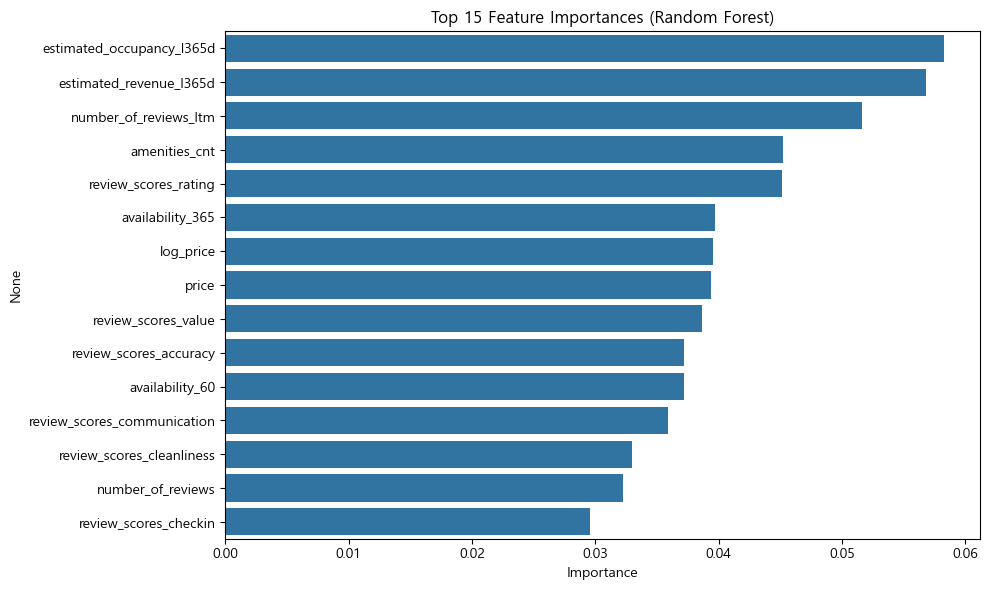

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [246]:
# 연관성탐색에서 변수중요도 기준으로 전략모델링 랜덤포레스트 
strategy_cols = ['amenities_cnt','availability_365','log_price','price','host_response_time_score','host_acceptance_rate_score','instant_bookable','host_about_length_group','room_type',
'neighbourhood_group_cleansed','host_has_profile_pic','neighborhood_overview_exists','name_length_group','description_length_group','is_long_term','accommodates','host_identity_verified','room_new_type']
# 중요 변수만 선택해서 전략 모델용 데이터셋 구성
X_top = df[strategy_cols]
X_top_encoded = pd.get_dummies(X_top)
# 학습/테스트 분할
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤포레스트로 학습 (전략 모델)
rf_top = RandomForestClassifier(n_estimators=300, random_state=42)
rf_top.fit(X_train_top, y_train_top)
# 평가 지표
y_pred_top = rf_top.predict(X_test_top)
y_proba_top = rf_top.predict_proba(X_test_top)[:, 1]

print("\n=== 전략 모델 성능 평가 (중요 변수만) ===")
print(classification_report(y_test_top, y_pred_top))
print("AUC:", roc_auc_score(y_test_top, y_proba_top))

# 변수 중요도
importances2 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances2.sort_values(ascending=False).round(2)


=== 전략 모델 성능 평가 (중요 변수만) ===
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3235
           1       0.77      0.52      0.62      1227

    accuracy                           0.83      4462
   macro avg       0.80      0.73      0.76      4462
weighted avg       0.82      0.83      0.81      4462

AUC: 0.8891841097208735

=== 변수 중요도 ===


amenities_cnt                                 0.16
availability_365                              0.14
price                                         0.12
log_price                                     0.12
accommodates                                  0.05
host_acceptance_rate_score                    0.05
host_response_time_score                      0.04
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
room_new_type_mid                             0.01
description_length_group_long                 0.01
description_length_group_short_or_avg         0.01
neighbourhood_group_cleansed_Queens           0.01
name_length_group_long                        0.01
room_type_Entire home/apt      

정확도 : 82%

AUC : 0.8874 0과 1사이에서 얼마나 잘 구분하는가

recall/ f1-score 슈퍼호스트 잡는 비율이 낮음(재현율)

#그대로 진행 
정밀도 우선: 확신이 있을 때만 슈퍼호스트라고 인정 
슈퍼호스트라고 판단한 사람은 거의 진짜임 (정밀도 82)
하지만 ‘슈퍼호스트 맞는데 확신이 덜해서 못 뽑는 경우’가 많아짐 (재현율 52)

#임계점을 낮춤
재현율 우선: 조금만 “슈퍼호스트일 가능성 있다” 해도 다 슈퍼호스트라고 인정
많은 슈퍼호스트를 잘 찾아냄 (재현율 상승 52에서 83으로 상승함)
하지만 ‘사실은 슈퍼호스트 아닌 사람’도 많이 슈퍼호스트라고 뽑음 (정밀도하락 82에서 79로 하락)

전략인사이트 도출이 메인
변수 중요도가 중요하고, 임계값은 부차적인듯 
일단 정밀도 82와 재현율52(절반이상은 잡아냄)모델 
변수중요도에 있어서는 신뢰할 수준 인듯 


In [235]:
#임계점 낮춤 
threshold = 0.3
y_pred_new = (y_proba_top >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_top, y_pred_new))

# 변수 중요도
importances3 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances3.sort_values(ascending=False).round(2)

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      3235
           1       0.59      0.83      0.69      1227

    accuracy                           0.79      4462
   macro avg       0.76      0.81      0.77      4462
weighted avg       0.83      0.79      0.80      4462


=== 변수 중요도 ===


amenities_cnt                                 0.17
availability_365                              0.15
price                                         0.13
log_price                                     0.12
accommodates                                  0.06
host_acceptance_rate_score                    0.05
host_response_time_score                      0.05
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
description_length_group_long                 0.01
name_length_group_short_or_med                0.01
neighbourhood_group_cleansed_Queens           0.01
description_length_group_short_or_avg         0.01
name_length_group_long                        0.01
host_identity_verified         

In [247]:
original_cols = ['amenities_cnt','availability_365','price','log_price','accommodates','host_acceptance_rate_score','host_response_time_score','is_long_term','instant_bookable','neighborhood_overview_exists','neighbourhood_group_cleansed',
    'host_about_length_group','description_length_group','name_length_group','host_identity_verified','room_type','host_has_profile_pic','room_new_type']

def find_group(feature_name, original_cols):
    for col in original_cols:
        if feature_name == col or feature_name.startswith(col + '_'):
            return col
    return '기타'

importance_df = importances2.reset_index()
importance_df.columns = ['feature', 'importance']

importance_df['group'] = importance_df['feature'].apply(lambda x: find_group(x, original_cols))

grouped_importance = importance_df.groupby('group')['importance'].sum().sort_values(ascending=False)

grouped_importance.round(2)

group
amenities_cnt                   0.16
availability_365                0.14
price                           0.12
log_price                       0.12
neighbourhood_group_cleansed    0.06
accommodates                    0.05
host_acceptance_rate_score      0.05
host_response_time_score        0.04
host_about_length_group         0.04
room_new_type                   0.04
description_length_group        0.03
room_type                       0.03
is_long_term                    0.03
name_length_group               0.03
instant_bookable                0.02
neighborhood_overview_exists    0.02
host_identity_verified          0.01
host_has_profile_pic            0.00
Name: importance, dtype: float64

중요도를 이전에 인코딩하면서 나뉘었던 변수들을 그룹으로 다시 묶어서 더해지게 계산해봄 
neighbourhood_group_cleansed 같은 경우 그룹으로 묶였을때 더 높아짐 
host_about_length_group이나 description_length_group도 그룹으로 했을때 높아짐 짧고 길고 소개글자체가 슈퍼호스트여부와 확실히 관련이 있다. 

중요도 기반 인사이트

| 순위 | 변수명                                      | 중요도     | 변수 설명          | 전략 방향 및 실행 방법                                                                  |
| -- | ---------------------------------------- | ------- | -------------- | ------------------------------------------------------------------------------ |
| 1  | `amenities_cnt`                          | **0.17**   | 숙소에 등록된 편의시설 수 | 다양한 편의시설 등록 → Wi-Fi, 세탁기, 주방, 냉장고, 에어컨, TV 등 기본 옵션 외에도 **욕실용품, 커피포트, 책상 등 추가** |
| 2  | `availability_365`                       | **0.15**  | 연중 예약 가능 일수    | 실제 일수 평균과 중앙값 비교했을때 슈퍼호스트가 아닌쪽이 더 많이 열려있음 (차이가 있어서 귀무가설은 기각했지만 인사이트적으로는...)                                        |
| 3  | `price` / `log_price`                    | **0.13/0.12** | 숙소 가격 / 로그 가격  | 너무 싸거나 너무 비싸지 않게, **지역 평균가와 비교하여 합리적 가격 설정**                                   |
| 4  | `accommodates`                           | 0.06    | 수용 가능 인원       | 귀무가설 기각못함(중앙값은 같고 평균도 0.1정도 차이로 인사이트내기에는 어려울듯 다른변수랑 더해서 생각)                  |
| 5  | `host_acceptance_rate_score`             | 0.05    | 예약 수락률         | 예약 요청은 **가능한 모두 수락**, 특별 사유가 없다면 거절 자제 (평균만 조금의 차이 중앙값은 같다)                                       |
| 6  | `host_response_time_score`               | 0.05    | 응답 속도 점수       | **24시간 내 응답은 필수**, 가급적 **1시간 이내 빠른 응답** 유지 ((평균만 조금의 차이 중앙값은 같다)                                       |)                                 |
| 7  | `is_long_term`                           | 0.03    | 장기 숙박 가능 여부    | 장기는 슈퍼호스트가 아닌 사람의 비율이 조금더 높고 단기는 슈퍼호스트가 높다 아마 단기로 많이 받는게 리뷰수가 많아질 가능성이 높아서 일듯                                     |
| 8  | `instant_bookable`                       | 0.02    | 즉시 예약 가능 여부    | 슈퍼호스트인 그룹은 0(즉시예약불가)가 80으로 훨씬 많음 1은 20대 즉시예약가능하지않아도 슈퍼호스트되는것에 상관없다                           |
| 9  | `host_about_length_group_long`           | 0.02    | 호스트 소개 글 길이    | **신뢰감 있는 소개글 작성 추천 (100자 이상)**                                       |
| 10 | `name_length_group_short_or_med`         | 0.02    | 숙소 이름 길이       | **짧고 직관적인 이름 설정** (예: Cozy Studio in Brooklyn)                                 |
| 11 | `neighborhood_overview_exists`           | 0.02    | 동네 소개 존재 여부    | **주변 지역 특징, 교통, 맛집, 안전성 등 있는게 유리**                                                 |
| 12 | `room_type_Private room`                 | 0.02    | 개인실 여부         | 비율로 확인했을때 큰차이없음                                           |
| 13 | `neighbourhood_group_cleansed_Manhattan` | 0.02    | 맨해튼 지역 여부      | 위치가 좋은 경우 강조: **‘도보로 \~분’, ‘중심지 위치’ 등 명시**                                     |
| 14 | `neighbourhood_group_cleansed_Brooklyn`  | 0.02    | 브루클린 지역 여부     |                                                |
| 15 | `description_length_group_long`          | 0.01    | 숙소 설명 글 길이     | 상세하게 쓰기: **숙소 구조, 편의시설, 주변시설, 체크인 방법 등 포함**                                    |
| 16 | `host_about_length_group_short_or_med`   | 0.01    | 중·단 소개글        | 장문보다는 낮은 중요도, **정보는 빠짐없이 간결하게**                                                |
| 17 | `description_length_group_short_or_avg`  | 0.01    | 중·단 숙소 설명      | 긴 설명이 더 효과적이므로 보완 필요                                                           |
| 18 | `host_has_profile_pic`                   | 0.01    | 프로필 사진 여부      | 기본이지만 중요함: **신뢰감을 위해 반드시 사진 등록**                                               |
| 19 | `neighbourhood_group_cleansed_Queens`    | 0.01    | 퀸즈 지역 여부       |                                               |
                                     |


'host_identity_verified'/'accommodates' 검정결과는 귀무가설기각 할수없었는데 모델링 과정에서 accommodates가 중요도 높게 나옴 단독으로는 변화가 없지만 다른 변수들과 함께 비교했을때 중요도 상승?
accommodates - 수요에 맞는 인원 설정. **1\~2인실은 깔끔함 강조**, **4인 이상은 가족/단체용으로 옵션 다양화

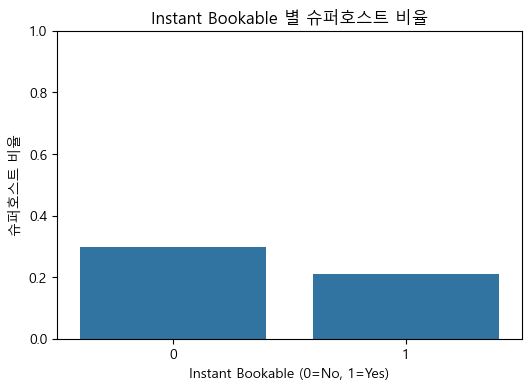

In [214]:
plt.rcParams['font.family'] = 'Malgun Gothic'

# instant_bookable 별 슈퍼호스트 비율 계산
rate_instant = df.groupby('instant_bookable')['host_is_superhost'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='instant_bookable', y='host_is_superhost', data=rate_instant)
plt.xlabel('Instant Bookable (0=No, 1=Yes)')
plt.ylabel('슈퍼호스트 비율')
plt.title('Instant Bookable 별 슈퍼호스트 비율')
plt.ylim(0, 1)
plt.show()

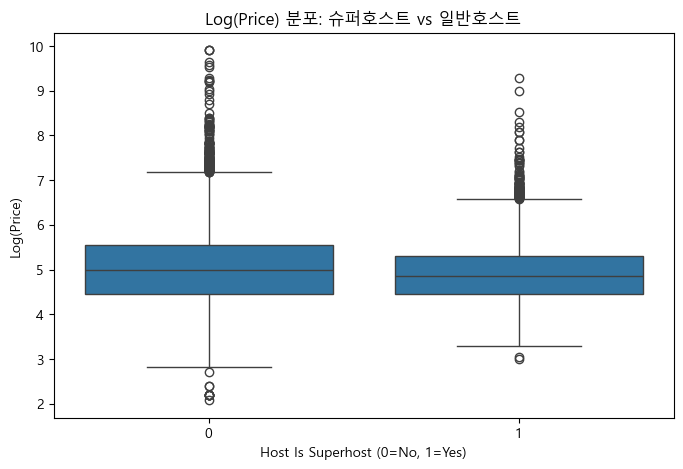

In [215]:
plt.figure(figsize=(8,5))
sns.boxplot(x='host_is_superhost', y='log_price', data=df)
plt.xlabel('Host Is Superhost (0=No, 1=Yes)')
plt.ylabel('Log(Price)')
plt.title('Log(Price) 분포: 슈퍼호스트 vs 일반호스트')
plt.show()